# PUBG Analysis
## Big Data Solution
Jessie Hung, Ying Huang, Kai Li

In [1]:
# import sys
# del sys.modules['os']
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

#spark sql imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, round, col
from pyspark.sql.functions import unix_timestamp, month, year, hour, minute, second, date_format
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, TimestampType 

import os 
import warnings
warnings.filterwarnings('ignore')

In [710]:
spark = SparkSession.builder.appName('PUBG').getOrCreate()
# conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '16g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
# spark.sparkContext.getConf().getAll() 
sc = spark.sparkContext

# Load Data

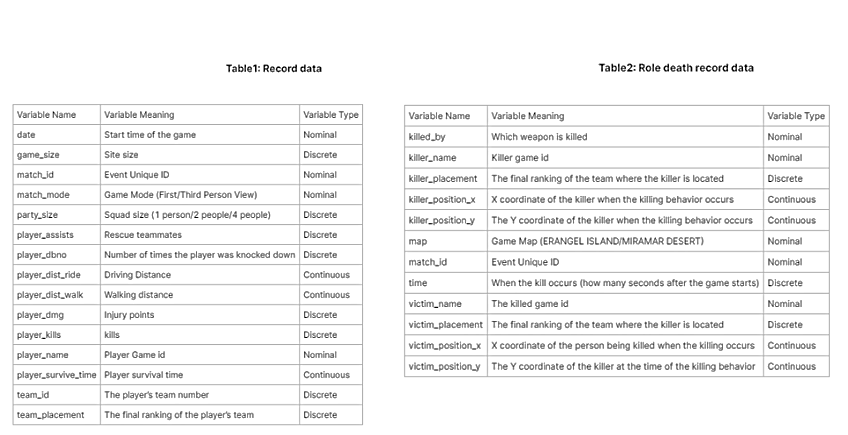

In aggregate, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.

In [492]:
agg0 = spark.read.csv('gs://pubg-data/pubg-match-deaths/aggregate/agg_match_stats_0.csv', inferSchema=True, header=True)
agg1 = spark.read.csv('gs://pubg-data/pubg-match-deaths/aggregate/agg_match_stats_1.csv', inferSchema=True, header=True)
agg2 = spark.read.csv('gs://pubg-data/pubg-match-deaths/aggregate/agg_match_stats_2.csv', inferSchema=True, header=True)
agg3 = spark.read.csv('gs://pubg-data/pubg-match-deaths/aggregate/agg_match_stats_3.csv', inferSchema=True, header=True)
agg4 = spark.read.csv('gs://pubg-data/pubg-match-deaths/aggregate/agg_match_stats_4.csv', inferSchema=True, header=True)
match = agg0.union(agg1)
match = match.union(agg2)
match = match.union(agg3)
match = match.union(agg4)

In [39]:
match.printSchema()

root
 |-- date: string (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_placement: integer (nullable = true)



In [9]:
match.show(1)

+--------------------+---------+--------------------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|                date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+--------------------+---------+--------------------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|        2870.724|      1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|
+--------------------+---------+--------------------+----------+----------+--------------+-----------+----------------+----------------+

In [10]:
match.count()

67369231

In deaths, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In [931]:
kil0 = spark.read.csv('gs://pubg-data/pubg-match-deaths/deaths/kill_match_stats_final_0.csv', inferSchema=True, header=True)
kil1 = spark.read.csv('gs://pubg-data/pubg-match-deaths/deaths/kill_match_stats_final_1.csv', inferSchema=True, header=True)
kil2 = spark.read.csv('gs://pubg-data/pubg-match-deaths/deaths/kill_match_stats_final_2.csv', inferSchema=True, header=True)
kil3 = spark.read.csv('gs://pubg-data/pubg-match-deaths/deaths/kill_match_stats_final_3.csv', inferSchema=True, header=True)
kil4 = spark.read.csv('gs://pubg-data/pubg-match-deaths/deaths/kill_match_stats_final_4.csv', inferSchema=True, header=True)
kill = kil0.union(kil1)
kill = kill.union(kil2)
kill = kill.union(kil3)
kill = kill.union(kil4)

In [932]:
kill.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: double (nullable = true)
 |-- killer_position_y: double (nullable = true)
 |-- map: string (nullable = true)
 |-- match_id: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: double (nullable = true)
 |-- victim_position_y: double (nullable = true)



In [8]:
kill.show(3)

+---------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|killed_by|     killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|    victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|  Grenade| KrazyPortuguese|             5.0|         657725.1|         146275.2|MIRAMAR|2U4GBNA0YmnLSqvEy...| 823|KrazyPortuguese|             5.0|         657725.1|         146275.2|
|   SCAR-L|nide2Bxiaojiejie|            31.0|         93091.37|         722236.4|MIRAMAR|2U4GBNA0YmnLSqvEy...| 194|    X3evolution|            33.0|         92238.68|         723375.1|
|     S686|        Ascholes|            43.0|         366921.4|         421

In [9]:
kill.count()

65370475

### Cast date timestamp

In [494]:
match.select('date').take(4)

[Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000'),
 Row(date='2017-11-26T20:59:40+0000')]

In [495]:
match = match.withColumn("date", F.unix_timestamp(match["date"], "yyyy-MM-dd'T'HH:mm:ss'+0000'").cast('timestamp'))
match.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- game_size: integer (nullable = true)
 |-- match_id: string (nullable = true)
 |-- match_mode: string (nullable = true)
 |-- party_size: integer (nullable = true)
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_name: string (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- team_placement: integer (nullable = true)



In [496]:
# Create columns year, month, time, hour 
match = match.withColumn('month', month(match['date']))
match = match.withColumn('year', year(match['date']))
split_col = F.split(match['date'], ' ')
match = match.withColumn('date_new', split_col.getItem(0))
match = match.withColumn('time', split_col.getItem(1))
split_col = F.split(match['time'], ':')
match = match.withColumn('hr', split_col.getItem(0))
match = match.withColumn('weekday', date_format('date', 'E'))

### Change match id to numeric

In [497]:
# Replace match_id with numeric id
match_id = match.select(match.match_id).distinct()
match_id_kill = kill.select('match_id').distinct()
match_id = match_id.union(match_id_kill).drop_duplicates(subset=['match_id'])
match_id = match_id.withColumn('id',F.monotonically_increasing_id())
match = match.join(match_id, on=['match_id'], how='left').drop('match_id')
kill = kill.join(match_id, on=['match_id'], how='left').drop('match_id')

In [34]:
match_id.count()  # 729998 unique match id

729998

In [513]:
match_map = kill.select(['map','id']).drop_duplicates(subset=['id'])
match_time = match.select(['date_new','time','weekday','hr','id']).drop_duplicates(subset=['id'])
match_info = match_map.join(match_time, on=['id'], how='left').orderBy(['date_new','weekday','time','hr'], ascending=[1,1])

In [514]:
match_info.printSchema()

root
 |-- id: long (nullable = true)
 |-- map: string (nullable = true)
 |-- date_new: string (nullable = true)
 |-- time: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- hr: string (nullable = true)



# EDA

## `Game heat by time and map`

In [515]:
match_info = match_info.withColumn('date_new', unix_timestamp('date_new', 'yyyy-MM-dd').cast('timestamp'))
match_info.printSchema()

root
 |-- id: long (nullable = true)
 |-- map: string (nullable = true)
 |-- date_new: timestamp (nullable = true)
 |-- time: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- hr: string (nullable = true)



In [511]:
match_info_11 = match_info.toPandas()

In [512]:
match_info_11.to_csv('match_info_11.csv')

In [501]:
match_info.show(3)

+-------------+-------+--------+----+-------+----+
|           id|    map|date_new|time|weekday|  hr|
+-------------+-------+--------+----+-------+----+
|1254130454080|ERANGEL|    null|null|   null|null|
|1194000912013|MIRAMAR|    null|null|   null|null|
|1202590846551|ERANGEL|    null|null|   null|null|
+-------------+-------+--------+----+-------+----+
only showing top 3 rows



In [522]:
match_mira = match_info.filter(match_info.map=='MIRAMAR').groupby('date_new').count().orderBy(['date_new'],ascending=[1]).withColumnRenamed('count','Miramar')
match_enra = match_info.filter(match_info.map=='ERANGEL').groupby('date_new').count().orderBy(['date_new'],ascending=[1]).withColumnRenamed('count','Erangel')
date_count = match_enra.join(match_mira, on=['date_new'], how='left')
date_count.printSchema()

root
 |-- date_new: timestamp (nullable = true)
 |-- Erangel: long (nullable = false)
 |-- Miramar: long (nullable = true)



In [517]:
match_mira.show(3)

+-------------------+-------+
|           date_new|Miramar|
+-------------------+-------+
|               null|      7|
|2017-12-21 00:00:00|   2813|
|2017-12-22 00:00:00|   7807|
+-------------------+-------+
only showing top 3 rows



In [524]:
date_count = date_count.na.fill(0).filter('date_new is not NULL').orderBy(['date_new'],ascending=[1]).toPandas()
date_count

date_new  Erangel  Miramar
0  2017-10-20     3608        0
1  2017-10-21     8354        0
2  2017-10-22     9335        0
3  2017-10-23     7634        0
4  2017-10-24     7272        0
..        ...      ...      ...
78 2018-01-06     5781     5851
79 2018-01-07     5704     5535
80 2018-01-08     4683     4538
81 2018-01-09     4278     4133
82 2018-01-10     2117     2127

[83 rows x 3 columns]

In [530]:
date_count 

Erangel  Miramar
date_new                    
2017-10-20     3608        0
2017-10-21     8354        0
2017-10-22     9335        0
2017-10-23     7634        0
2017-10-24     7272        0
...             ...      ...
2018-01-06     5781     5851
2018-01-07     5704     5535
2018-01-08     4683     4538
2018-01-09     4278     4133
2018-01-10     2117     2127

[83 rows x 2 columns]

<IPython.core.display.Javascript object>


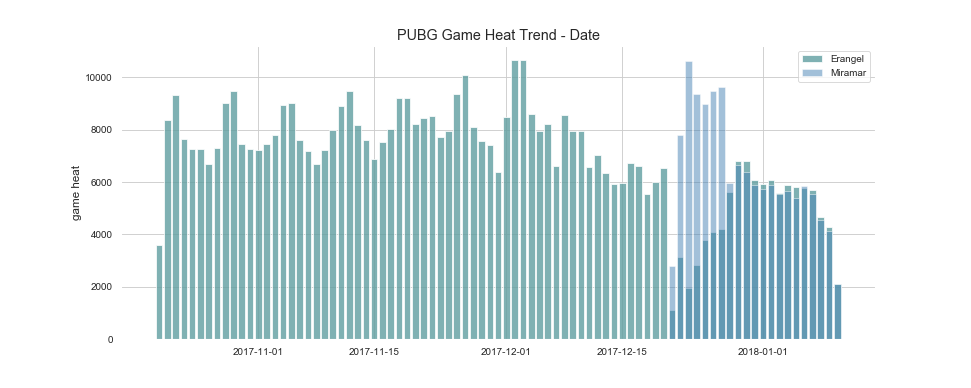

In [924]:
%matplotlib notebook
rc = {'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.family':'sans-serif',
      'font.size' : 12}
plt.rcParams.update(rc)
# sns.set(font_scale=1.5)
# sns.set_style("darkgrid")


# date_count = date_count.set_index('date_new')

fig, ax = plt.subplots(figsize=(15,6)) 
plt.bar(date_count.index.values, date_count['Erangel'],  alpha=0.8, color='cadetblue', label='Erangel')
plt.bar(date_count.index.values, date_count['Miramar'],  alpha=0.5, color='steelblue', label='Miramar')
plt.legend()
plt.title('PUBG Game Heat Trend - Date', fontsize=16)
plt.ylabel('game heat',fontsize=13)
# plt.xticks(['2017-10-20','2017-11-06','2017-11-23','2017-12-09','2017-12-25','2018-10'],\
#            ['Oct 20, 2017','Nov 6, 2017','Nov 23, 2017','Dec 9, 2017','Dec 25, 2017\nChristmas','Jan 10, 2018'], fontsize=12) # rotation=90

plt.show()


### By this Graph: 
    - We observe clear weekly time series pattern
    - New map Miramar launch at 2017-12-21, triggered huge enthusiasm and reached the peak at 2017 Christmas, but quickly faded after a week
    - Later, no clear preference between two maps

In [564]:
match_weekday = match_info.select(['date_new','weekday','id']).dropna(subset=['date_new']).groupby(['date_new','weekday']).count()\
.toPandas()

week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
week_num = [1,2,3,4,5,6,7]
match_weekday = match_weekday.replace(week,week_num)

<IPython.core.display.Javascript object>


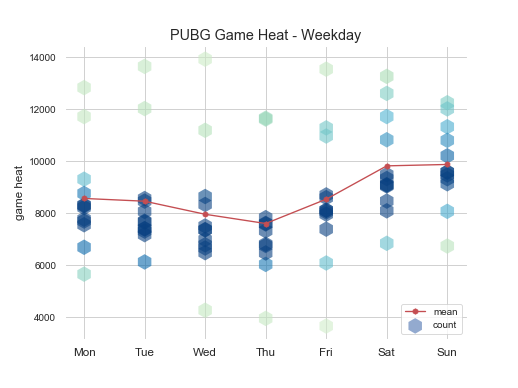

In [929]:
fig, axes = plt.subplots(figsize=(8,6)) 
# fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
# plt.subplot(2,2,1)

xy = np.vstack([match_weekday.weekday, match_weekday['count']])
z = gaussian_kde(xy)(xy)


idx = z.argsort()
x, y, z = [match_weekday.weekday[idx], match_weekday['count'][idx], z[idx]]

cm = plt.cm.get_cmap('GnBu')
plt.scatter(x, y, c=z, s=300, cmap=cm, vmin=-0.000002, vmax=0.000022, edgecolor='', alpha=0.6, marker='h',label='count')

weekday_mean = match_weekday.groupby(['weekday'], as_index=False).mean()
plt.plot('weekday', 'count', data=weekday_mean, color='r', marker='h', label='mean')

plt.title('PUBG Game Heat - Weekday',fontsize=16)
plt.ylabel('game heat',fontsize=13)
plt.xticks(week_num, week, fontsize=13)
plt.legend(loc='lower right')
# plt.colorbar(sc)
plt.show()

In [554]:
match_hr = match_info.select(['date_new','hr','id']).dropna(subset=['date_new']).groupby(['date_new','hr']).count()

In [557]:
match_hr = match_hr.withColumn('hr', match_hr.hr.cast(IntegerType())).toPandas()
match_hr.printSchema()

root
 |-- date_new: timestamp (nullable = true)
 |-- hr: integer (nullable = true)
 |-- count: long (nullable = false)



<IPython.core.display.Javascript object>


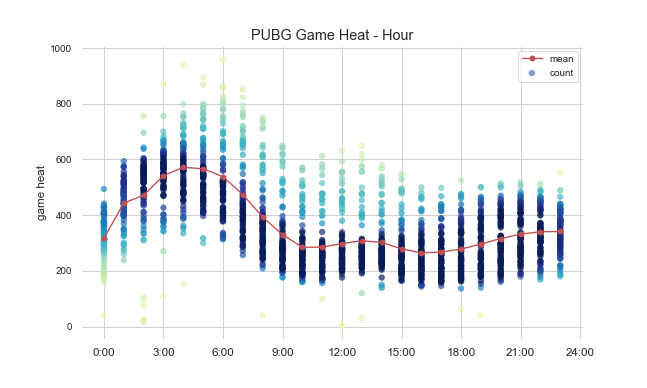

In [593]:
fig, axes = plt.subplots(figsize=(10,6)) 
# subplot(2,2,2)

xy = np.vstack([match_hr.hr, match_hr['count']])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = [match_hr.hr[idx], match_hr['count'][idx], z[idx]]

sc = plt.scatter(x, y, c=z, s=50, vmin=-0.000012, vmax=0.0001,cmap= 'YlGnBu',edgecolor='', alpha=0.7, label='count')

hr_mean = pd.DataFrame(match_hr.groupby(['hr']).mean())
plt.plot(hr_mean.index, hr_mean['count'].values, color='r', marker='h', label='mean')

plt.title('PUBG Game Heat - Hour', fontsize=16)
plt.ylabel('game heat',fontsize=13)
plt.xticks([0,3,6,9,12,15,18,21,24],["0:00","3:00","6:00","9:00","12:00","15:00","18:00","21:00","24:00"], fontsize=13)
# plt.colorbar(sc)
plt.legend()
plt.show()

From the above two graphs:
    - Lots of late/midnight players
    - Weekends have more players obviously
    


In [28]:
match_joined = match.join(match_map, on = ['id'], how = 'left')

In [29]:
match_joined.groupby('map','party_size').count().show()

+-------+----------+--------+
|    map|party_size|   count|
+-------+----------+--------+
|MIRAMAR|         1| 2141767|
|ERANGEL|         2|17509116|
|   null|         1|  234143|
|ERANGEL|         4|24807340|
|   null|         4|  736663|
|MIRAMAR|         4| 6177311|
|MIRAMAR|         2| 3570920|
|   null|         2|  528232|
|ERANGEL|         1|11663739|
+-------+----------+--------+



## `Team stats`


### Average distance of walking and riding 


In [30]:
match_joined.groupby('map','party_size').avg('player_dist_walk').orderBy('avg(player_dist_walk)', ascending =[0]).show()

+-------+----------+---------------------+
|    map|party_size|avg(player_dist_walk)|
+-------+----------+---------------------+
|MIRAMAR|         4|   1411.4663998748542|
|ERANGEL|         4|   1361.6102624102944|
|   null|         4|   1319.8099977893526|
|MIRAMAR|         2|   1279.6865594108742|
|ERANGEL|         2|   1226.5914382717735|
|   null|         2|   1209.4242308998919|
|MIRAMAR|         1|   1181.7354003796431|
|ERANGEL|         1|   1162.0253086139683|
|   null|         1|    1152.455547969052|
+-------+----------+---------------------+



In [31]:
%time match_joined.groupby('map','party_size').avg('player_dist_ride').orderBy('avg(player_dist_ride)', ascending =[0]).show()

+-------+----------+---------------------+
|    map|party_size|avg(player_dist_ride)|
+-------+----------+---------------------+
|ERANGEL|         4|   1345.5841401616506|
|   null|         4|   1262.8566999030118|
|ERANGEL|         2|   1176.0971599638344|
|   null|         2|   1128.7379526080842|
|MIRAMAR|         4|   1055.8883898729403|
|MIRAMAR|         2|    977.3760415701894|
|ERANGEL|         1|    907.7270210065767|
|   null|         1|    865.2656117881621|
|MIRAMAR|         1|    745.9101817781357|
+-------+----------+---------------------+

Wall time: 3min 38s


### Average survival time by party size

In [95]:
match_party4 = match.filter(match.party_size == 2).groupby(['id','team_id']).\
    agg(F.avg('party_size'),F.avg('player_survive_time'),F.sum('player_kills'),F.avg('team_placement'),\
        F.avg('player_dist_ride'), F.avg('player_dist_walk')).\
    orderBy(['id','avg(player_survive_time)','avg(team_placement)'],ascending=[1,0,0])
# data_p4stats = match_party4.summary().toPandas()
match_party4.describe().show()

+-------+--------------------+------------------+---------------+------------------------+------------------+-------------------+---------------------+---------------------+
|summary|                  id|           team_id|avg(party_size)|avg(player_survive_time)| sum(player_kills)|avg(team_placement)|avg(player_dist_ride)|avg(player_dist_walk)|
+-------+--------------------+------------------+---------------+------------------------+------------------+-------------------+---------------------+---------------------+
|  count|            10981317|          10981317|       10981317|                10981317|          10981317|           10981317|             10981317|             10981317|
|   mean|8.548783729996472E11|25.726904068063966|            2.0|      12354.502707191932| 1.765588590148158| 24.915508859274347|   1131.3894223358018|   1225.5155046061518|
| stddev|4.961715271582933...|14.497078279940716|            0.0|     1.920697404240227E7|2.4242697915576246| 14.138745893847267| 

In [94]:
match_party2 = match.filter(match.party_size == 2).groupby(['id','team_id']).\
    agg(F.avg('party_size'),F.avg('player_survive_time'),F.sum('player_kills'),F.avg('team_placement'),\
        F.avg('player_dist_ride'), F.avg('player_dist_walk')).\
    orderBy(['id','avg(player_survive_time)','avg(team_placement)'],ascending=[1,0,0])
# data_p2stats = match_party2.summary().toPandas()
match_party2.describe().show()

+-------+--------------------+------------------+--------------------+------------------------+------------------+-------------------+---------------------+---------------------+
|summary|                  id|           team_id|     avg(party_size)|avg(player_survive_time)| sum(player_kills)|avg(team_placement)|avg(player_dist_ride)|avg(player_dist_walk)|
+-------+--------------------+------------------+--------------------+------------------------+------------------+-------------------+---------------------+---------------------+
|  count|            10981317|          10981317|            10981317|                10981317|          10981317|           10981317|             10981317|             10981317|
|   mean|8.548783729996478E11|25.726904068063966|                 2.0|      12354.502707191949| 1.765588590148158| 24.915508859274347|   1131.3894223358018|   1225.5155046061518|
| stddev|4.961715271582919E11| 14.49707827994072|2.187402823010323...|    1.9206974042402115E7|2.42426979

In [96]:
match_party1 = match.filter(match.party_size == 2).groupby(['id','team_id']).\
    agg(F.avg('party_size'),F.avg('player_survive_time'),F.sum('player_kills'),F.avg('team_placement'),\
        F.avg('player_dist_ride'), F.avg('player_dist_walk')).\
    orderBy(['id','avg(player_survive_time)','avg(team_placement)'],ascending=[1,0,0])
# data_p1stats = match_party1.summary().toPandas()
match_party1.describe().show()

+-------+--------------------+------------------+---------------+------------------------+-----------------+-------------------+---------------------+---------------------+
|summary|                  id|           team_id|avg(party_size)|avg(player_survive_time)|sum(player_kills)|avg(team_placement)|avg(player_dist_ride)|avg(player_dist_walk)|
+-------+--------------------+------------------+---------------+------------------------+-----------------+-------------------+---------------------+---------------------+
|  count|            10981317|          10981317|       10981317|                10981317|         10981317|           10981317|             10981317|             10981317|
|   mean|8.548783729996434E11|25.726904068063966|            2.0|      12354.502707191945|1.765588590148158| 24.915508859274347|   1131.3894223358009|   1225.5155046061514|
| stddev|4.961715271582900...|14.497078279940713|            0.0|    1.9206974042402152E7|2.424269791557626|  14.13874589384726|   1869

In [922]:
data_p1stats = data_p1stats.drop(['id','team_id','placement','party_size'],axis=1).set_index('summary').astype('int64')
data_p2stats = data_p2stats.drop(['id','team_id','placement','party_size'],axis=1).set_index('summary').astype('int64')
data_p4stats = data_p4stats.drop(['id','team_id','placement','party_size'],axis=1).set_index('summary').astype('int64')
data_p1stats

avg_survive_time  total_kill  total_assists  total_dbno  \
summary                                                            
count            14039649    14039649       14039649    14039649   
mean               145792           0              0           0   
stddev           96089538           1              0           0   
min                     0           0              0           0   
25%                   207           0              0           0   
50%                   578           0              0           0   
75%                  1178           1              0           0   
max           63647875100          94              6           0   

         avg_ride_dist  avg_walk_dist  
summary                                
count         14039649       14039649  
mean               882           1164  
stddev            1854           5308  
min                  0              0  
25%                  0            151  
50%                  0            688  
75%               1105           1819  
max             442536        1188375

In [260]:
data_p2stats

avg_survive_time  total_kill  total_assists  total_dbno  \
summary                                                            
count            10981317    10981317       10981317    10981317   
mean                12354           1              0           1   
stddev           19206974           2              0           1   
min                     0           0              0           0   
25%                   255           0              0           0   
50%                   628           1              0           1   
75%                  1212           2              1           2   
max           31824108320          78             18          42   

         avg_ride_dist  avg_walk_dist  
summary                                
count         10981317       10981317  
mean              1131           1225  
stddev            1869           3054  
min                  0              0  
25%                  0            222  
50%                  0            831  
75%               1833           1940  
max             254516         897151

In [261]:
data_p4stats

avg_survive_time  total_kill  total_assists  total_dbno  \
summary                                                            
count             9192801     9192801        9192801     9192801   
mean                19280           3              1           2   
stddev           26530186           3              1           2   
min                     0           0              0           0   
25%                   330           0              0           1   
50%                   724           2              0           2   
75%                  1259           4              2           4   
max           63648215000          71             28         152   

         avg_ride_dist  avg_walk_dist  
summary                                
count          9192801        9192801  
mean              1254           1340  
stddev            1811           2234  
min                  0              0  
25%                  0            326  
50%                216           1051  
75%               2112           2102  
max             163364        1006273

### By team Statistics:
    - Looking at the max: we may have hackers(so we want to detect hackers later), but more likely we just have bad data
    - Due to the bad data, mean and standard deviation are not very meaningful
    - Usually, squad has longer survive time (confirmed later)
    - Not many kills (also confirmed later)
    - People do not like to assists, even it's party of 4
    - Only ride when it's team of 4

#### Survival time distribution by group-size

In [33]:
df1 = match.sample(withReplacement = False, fraction = 0.0001, seed=0).\
        join(kill.select('id','map'), match.id == kill.id, 'left').\
        select('player_survive_time','party_size','map').toPandas()

In [34]:
df1.shape

(600262, 3)

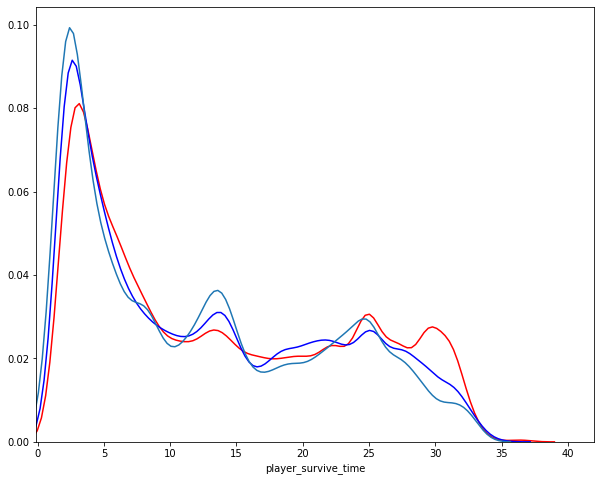

In [35]:
plt.figure(figsize=(10,8))
plt.xlim(-0.1, 42)
sns.distplot(df1[df1['party_size'] == 4]['player_survive_time']/60,hist=False, color = 'r')
sns.distplot(df1[df1['party_size'] == 2]['player_survive_time']/60,hist=False, color = 'b')
sns.distplot(df1[df1['party_size'] == 1]['player_survive_time']/60,hist=False)

## `Death position `

### Death position  with in 4 minutes

In [326]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://storage.googleapis.com/data-pubg/data/miramar.jpg")
miramar_map = Image.open(BytesIO(response.content))
response2 = requests.get("https://storage.googleapis.com/data-pubg/data/erangel_1.jpg")
erangel_map = Image.open(BytesIO(response2.content))

In [327]:
erangel_map = erangel_map.resize((1000,1000))
print(erangel_map.width)
print(miramar_map.width)

1000


1000

In [328]:
#seperate two map
miramar = kill.filter(kill.map == 'MIRAMAR')
erangel = kill.filter(kill.map == 'ERANGEL')

In [41]:
db4_m = miramar.filter(miramar.time <= 240).select('victim_position_x','victim_position_y')
db4_m = db4_m.toPandas()
db4_m.count()

3023714

In [99]:
db4_e = erangel.filter(erangel.time <= 240).select('victim_position_x','victim_position_y')
db4_e = db4_e.sample(withReplacement = False, fraction = 0.0001, seed=0).select('victim_position_x','victim_position_y').\
            dropna().toPandas()

<IPython.core.display.Javascript object>


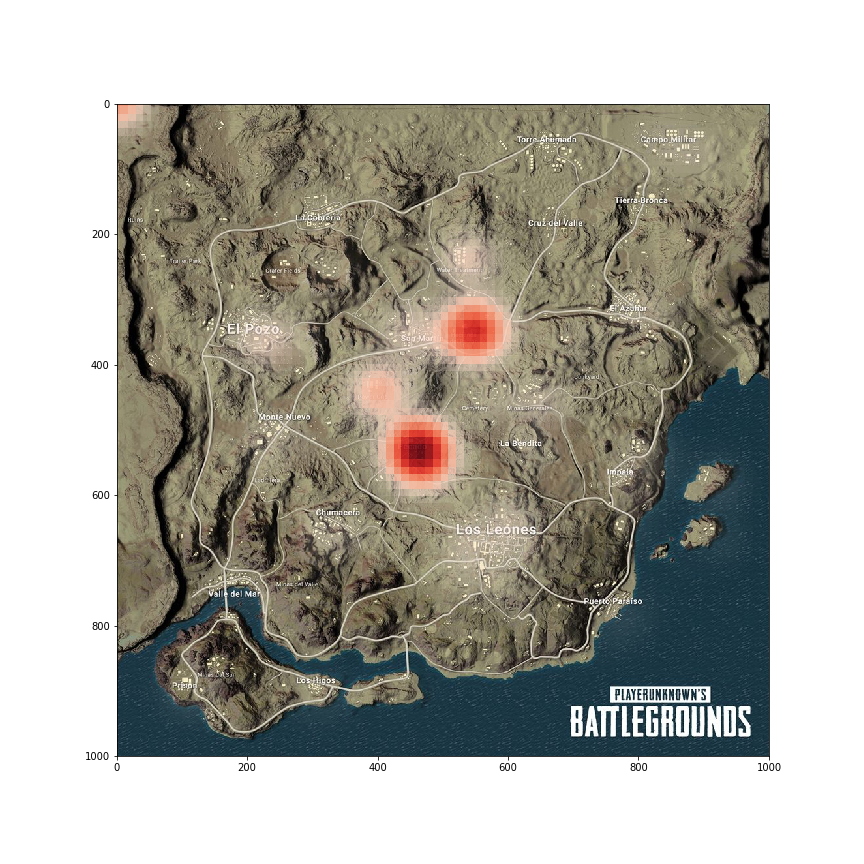

In [112]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy as np

def heatmap(x, y, s, bins=100):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

#bg = imread('../input/erangel.jpg')
hmap, extent = heatmap(db4_m['victim_position_x']/800, db4_m['victim_position_y']/800, 2.5)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*5, 0.0, 1.)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.Reds(colors)
colors[..., -1] = alphas

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000)
ax.imshow(miramar_map)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=0.9)
#plt.scatter(plot_data_er[:,0], plot_data_er[:,1])
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


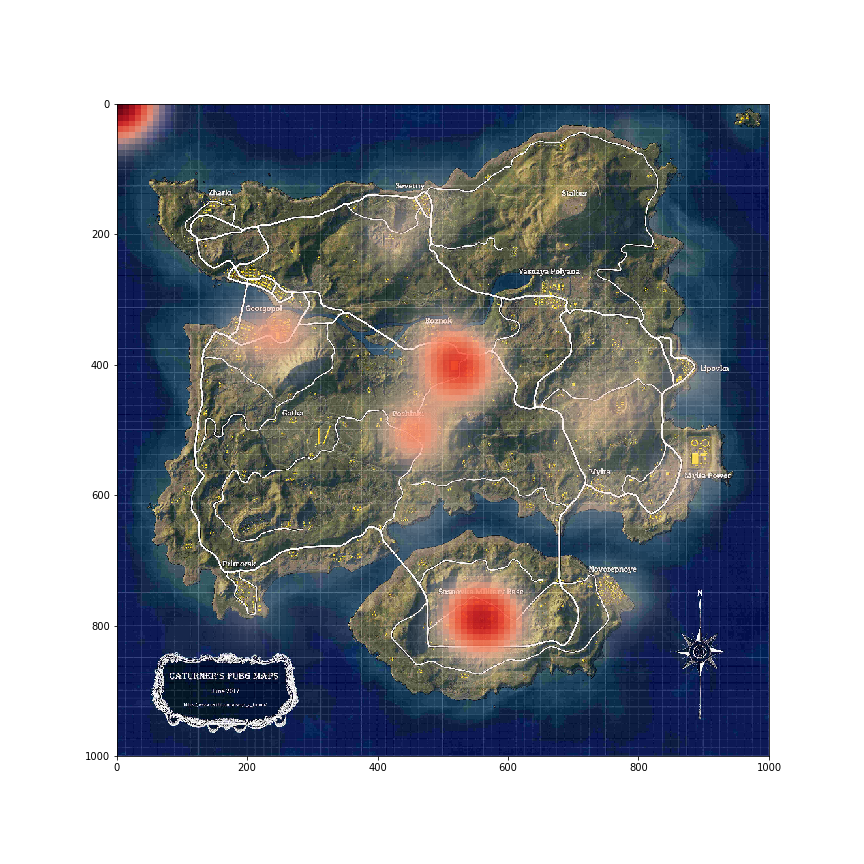

In [113]:
#bg = imread('../input/erangel.jpg')
hmap, extent = heatmap(db4_e['victim_position_x']/800, db4_e['victim_position_y']/800, 4)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*3, 0.0, 1.)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.Reds(colors)
colors[..., -1] = alphas

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000)
ax.imshow(erangel_map)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=0.9)
plt.gca().invert_yaxis()

### Death position in a single match

In [57]:
miramar.select('id').distinct().show(5,truncate=False)

+----------+
|id        |
+----------+
|1677      |
|474       |
|1950      |
|8589936870|
|8589934965|
+----------+
only showing top 5 rows



In [332]:
match1 = miramar.filter(miramar.id == 1677).orderBy('time',ascending=[1]).toPandas()
match1.head()

killed_by killer_name  killer_placement  killer_position_x  \
0       M416  HuaiDanXin              27.0           710971.5   
1  Tommy Gun   TG4_BaiQi               5.0           667362.4   
2    Grenade      J-XiXi              18.0           706405.4   
3        AKM     Warm652              21.0           719616.9   
4      P1911   Chine-007               1.0           371134.2   

   killer_position_y      map  time   victim_name  victim_placement  \
0           53143.76  MIRAMAR   134  future-snake              19.0   
1           41150.40  MIRAMAR   136      pangzida              20.0   
2           57005.77  MIRAMAR   141    thebutchui              27.0   
3           64223.65  MIRAMAR   149   HandsomeHSS              27.0   
4          421379.00  MIRAMAR   153        zlpzzz              12.0   

   victim_position_x  victim_position_y    id  
0           710995.4           53020.87  1677  
1           667639.6           41316.24  1677  
2           710875.8           53031.94  1677  
3           719316.8           64387.28  1677  
4           370994.9          420994.90  1677

<IPython.core.display.Javascript object>


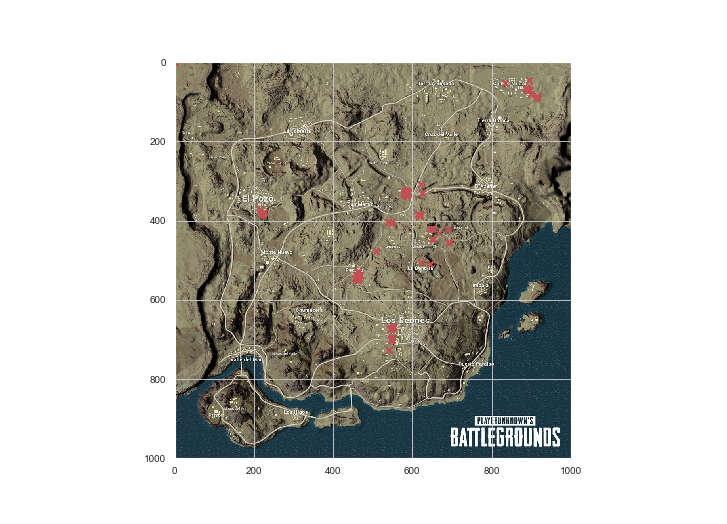

In [448]:
import matplotlib.animation as animation
# %matplotlib notebook

fig = plt.figure(figsize=(6,6))
plt.xlim(0, 1000)
plt.ylim(1000, 0)

def animate(i):
    data = match1.iloc[:int(i+1),9:11]/800
    #sns.scatterplot(x='victim_position_x', y='victim_position_y', data=data, palette = "RdBu")
    plt.scatter(data['victim_position_x'],data['victim_position_y'],c='r',marker='x')
         
ani = animation.FuncAnimation(fig, animate, frames = match1.shape[0],repeat=False)
plt.imshow(miramar_map)
plt.show()

ani.save('myAnimation.gif', writer='pillow', fps=30)

## `Savezone`

In [138]:
mira_pois = miramar.filter(miramar.time > 2000).select('victim_position_x','victim_position_y','killer_position_x','killer_position_y').dropna()
enra_pois = erangel.filter(erangel.time > 2000).select('victim_position_x','victim_position_y','killer_position_x','killer_position_y').dropna()
mira_pois = mira_pois.filter(mira_pois.victim_position_x !=0).filter(mira_pois.killer_position_y !=0).filter(mira_pois.victim_position_y !=0).filter(mira_pois.killer_position_x !=0)
enra_pois = enra_pois.filter(enra_pois.victim_position_x !=0).filter(enra_pois.killer_position_y !=0).filter(enra_pois.victim_position_y !=0).filter(enra_pois.killer_position_x !=0)
mira_pois_victim = mira_pois.select('victim_position_x','victim_position_y')
mira_pois_killer = mira_pois.select('killer_position_x','killer_position_y')
mira_pois = mira_pois_victim.union(mira_pois_killer).toPandas()
enra_pois_victim = enra_pois.select('victim_position_x','victim_position_y')
enra_pois_killer = enra_pois.select('killer_position_x','killer_position_y')
enra_pois = enra_pois_victim.union(enra_pois_killer).toPandas()

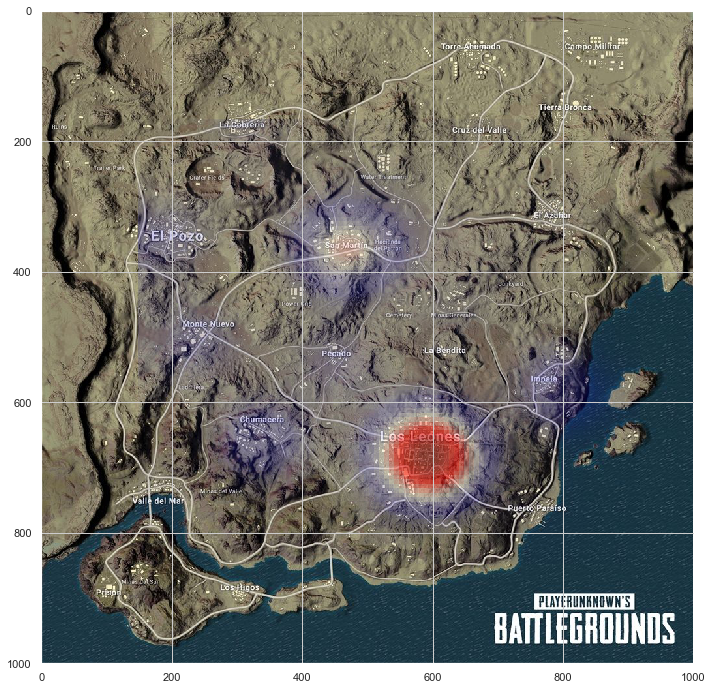

In [219]:
hmap, extent = heatmap(mirapois['victim_position_x']/800, mirapois['victim_position_y']/800, 7)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*1, 0, 0.8)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.seismic(colors)
colors[..., -1] = alphas


fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000)
ax.imshow(miramar_map)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.seismic, alpha=0.7)
#plt.scatter(plot_data_er[:,0], plot_data_er[:,1])
plt.gca().invert_yaxis()

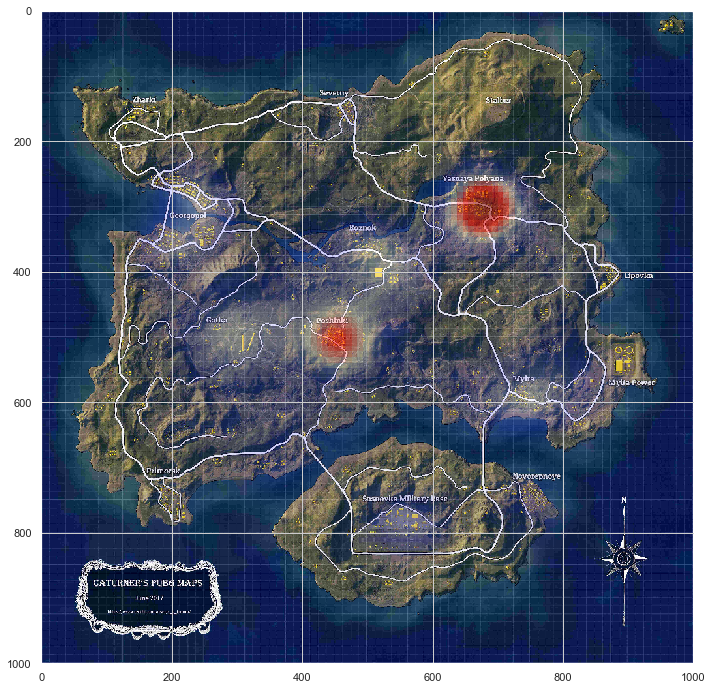

In [209]:
hmap, extent = heatmap(enrapois['victim_position_x']/800, enrapois['victim_position_y']/800,4)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*1, 0, 0.8)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.seismic(colors)
colors[..., -1] = alphas


fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim(0, 1000); ax.set_ylim(0, 1000)
ax.imshow(erangel_map)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.seismic, alpha=0.7)
plt.gca().invert_yaxis()

## `Player kills in a match`

In [665]:
play_kill = match.groupby(['player_kills']).count().orderBy(['player_kills'],ascending=[1])
play_kill = play_kill.withColumn('percent', F.col('count')/F.sum('count').over(Window.partitionBy()))

In [669]:
play_kill_1 = play_kill.limit(11).orderBy(['player_kills'], ascending=[1]).withColumn('percent', round(col('percent')*100,2))\
.withColumn('count', round(col('count')/1000,2)).toPandas()

In [654]:
play_kill10 = play_kill.filter(play_kill.player_kills>9).agg(F.sum('count')).collect()[0]['sum(count)']
play_kill10

230619

In [671]:
play_kill_1.loc[10,'count']=play_kill10/1000
play_kill_1['player_kills']=['0 kill','1 kill','2 kills','3 kills','4 kills','5 kills','6 kills','7 kills','8 kills','9 kills','10+ kills']
play_kill_1.head(11)

player_kills      count  percent
0        0 kill  39120.050    58.07
1        1 kill  14022.010    20.81
2       2 kills   6956.400    10.33
3       3 kills   3317.860     4.92
4       4 kills   1724.670     2.56
5       5 kills    904.420     1.34
6       6 kills    509.770     0.76
7       7 kills    294.650     0.44
8       8 kills    178.080     0.26
9       9 kills    110.720     0.16
10    10+ kills    230.619     0.11

In [708]:
x = play_kill_1.player_kills.values
y_count = play_kill_1['count'].values
y_percent  = play_kill_1.percent.values

fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                    shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(x=y_percent, y=x, 
    marker=dict(color='rgba(58, 125, 130,0.6)',line=dict(color='rgba(58, 125, 130, 0.6)',width=1),
    ),name='Percentage of Player kill number per match', orientation='h',), 1, 1)

fig.append_trace(go.Scatter(x=y_count, y=x,
    mode='lines+markers',line_color='rgb(109, 128, 182)',
                            name='Aggregate of player kills number per match',), 1, 2)

fig.update_layout(
    title='PUBG Player Kill Number per Match',
    yaxis=dict(showgrid=False, showline=False, showticklabels=True, domain=[0, 0.88],),
    yaxis2=dict(showgrid=False, showline=True, showticklabels=False, domain=[0, 0.88],), # linecolor='rgba(102, 102, 102, 0.8)',linewidth=2,
    xaxis=dict(zeroline=False, showline=False, showticklabels=True, showgrid=True, domain=[0, 0.42],),
    xaxis2=dict(zeroline=False, showline=False, showticklabels=True, showgrid=True, domain=[0.44, 1],
        side='top', dtick=25000,),
    legend=dict(x=0.029, y=1.038, font_size=10), margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)',)


annotations = []

y_s = np.round(y_percent, decimals=2)
y_nw = y_count.astype('int64')

# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x):
    # labeling the scatter
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=ydn-3500,
                            text='{:,}'.format(ydn)+'K', font=dict(family='Arial', size=13,
                                      color='rgb(109, 128, 182)'), showarrow=False))
    # labeling the bar
    annotations.append(dict(xref='x1', yref='y1', y=xd, x=yd+6,
                            text=str(yd) + '%', font=dict(family='Arial', size=13,
                                      color='rgb(58, 125, 130)'), showarrow=False))   
    
annotations.append(dict(xref='paper', yref='paper',
                        x=-0.06, y=-.120,
                        text='PUBG match dataset - 67 million rows; PUBG deaths dataset - 65 million rows',
                        font=dict(family='Arial', size=12, color='rgb(150,150,150)'),
                        showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

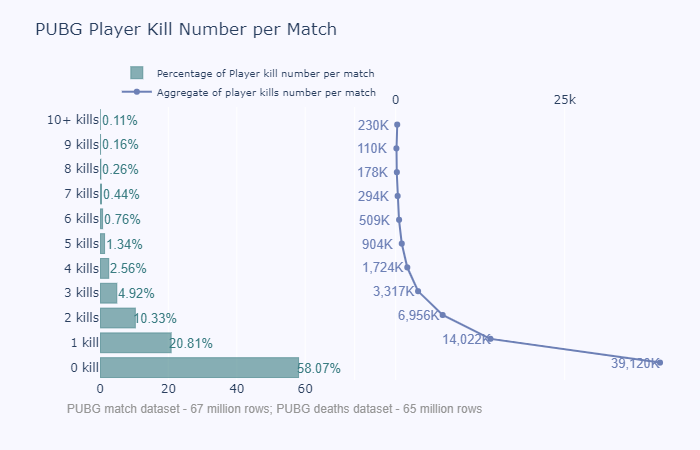

### By killer Number:
    - Really not many kills

## `Top Causes of death`


In [711]:
firearm_list = ['P18C','P1911','P92','R1895','R45','Win94','S1897','S686','S12K','UMP9','Micro UZI','Vector','Tommy Gun','AKM','death.WeapSawnoff_C',\
          'M416','SCAR-L','M16A4','AUG','Groza','M249','DP-28','VSS','Mini 14','SKS','Mk14','Kar98k','M24','AWM','Grenade','death.ProjMolotov_DamageField_C']
schema = StructType([StructField('killed_by', StringType(), True)])
rdd = sc.parallelize(firearm_list).map(lambda x: Row(x))
firearm = spark.createDataFrame(rdd, schema)
firearm.show(3)

+---------+
|killed_by|
+---------+
|     P18C|
|    P1911|
|      P92|
+---------+
only showing top 3 rows



In [52]:
killed_all = kill.groupBy('killed_by').count()
killed_firearm = firearm.join(killed_all, on=['killed_by'], how='left').orderBy(['count'], ascending=[0])
killed_firearm = killed_firearm.withColumn('count', firearm.count.cast(IntegerType())/1000)

In [53]:
killed_other = killed_all.filter(~killed_all['killed_by'].isin(firearm_list)).orderBy(['count'], ascending=[0])\
killed_other = killed_other.withColumn('count', firearm.count.cast(IntegerType())/1000).toPandas()
killed_other['count'] = killed_other['count'].astype('float64')

killed_other['count'] = killed_other['count']/1000
killed_firearm.head(15).killed_by.values

array(['M416', 'SCAR-L', 'M16A4', 'AKM', 'UMP9', 'S1897', 'Mini 14',
       'Kar98k', 'S686', 'SKS', 'S12K', 'Micro UZI', 'Grenade',
       'Tommy Gun', 'P1911'], dtype=object)

In [92]:
x_firearm = killed_firearm.head(15).killed_by.values
y_firearm = killed_firearm.head(15)['count'].values.astype('int64')
x_other = killed_other.head(15).killed_by.values
y_other = killed_other.head(15)['count'].values.astype('int64')

fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True, shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(go.Bar(x=y_firearm, y=x_firearm, 
    marker=dict(color='rgba(182, 109, 112, 0.7)',line=dict(color='rgba(182, 109, 112, 0.7)',width=1),
    ),name='Top 15 Firearm-related Deaths', orientation='h',), 1, 1)

fig.append_trace(go.Bar(x=y_other, y=x_other , 
    marker=dict(color='rgba(158, 123, 167, 0.7)',line=dict(color='rgba(158, 123, 167, 0.7)',width=1),
    ),name='Other Causes of Death', orientation='h',), 1, 2)

fig.update_layout(title='Top Causes of Death in PUBG',
    yaxis=dict(showgrid=False, showline=False, showticklabels=True, domain=[0, 0.88],),
    yaxis2=dict(showgrid=False, showline=True, showticklabels=True, domain=[0, 0.88],),
    xaxis=dict(zeroline=False, showline=False, showticklabels=True, showgrid=True, domain=[0, 0.42],),
    xaxis2=dict(zeroline=False, showline=False, showticklabels=True, showgrid=True, domain=[0.55, 1],),
    legend=dict(x=0.029, y=1.038, font_size=10), margin=dict(l=100, r=20, t=70, b=70),
    paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)',)

annotations = []

# Adding labels
for ydn, yd, xdn, xd in zip(y_firearm, y_other, x_firearm, x_other):
    annotations.append(dict(xref='x1', yref='y1', y=xdn, x=ydn+800,
                            text='{:,}'.format(ydn)+'K', font=dict(family='Arial', size=12,
                                      color='rgb(182, 109, 112)'), showarrow=False))
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=yd+1300,
                            text='{:,}'.format(yd)+'K', font=dict(family='Arial', size=12,
                                      color='rgb(158, 123, 167)'), showarrow=False))

fig.update_layout(annotations=annotations)
fig.show()

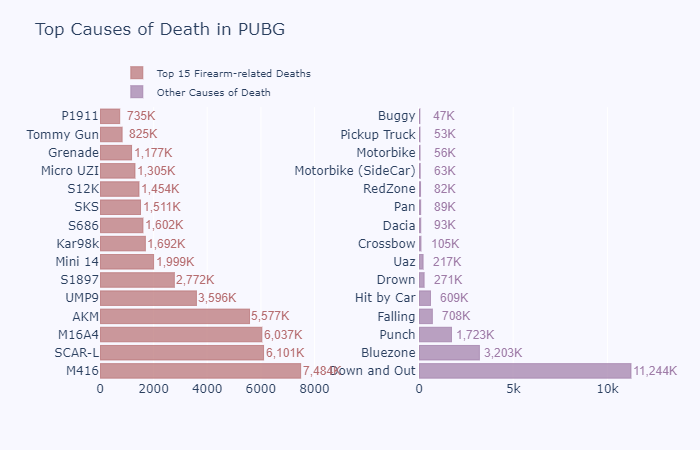

### By causes of death:
    - M416 is really popular 
    - Most is down and out

## `Killing distance`

Divede the position by 100 to convert to unit in meter since the map is 8km by 8km

In [560]:
kill = kill.withColumn('kill_distance',F.sqrt((kill.killer_position_x/100-kill.victim_position_x/100)**2+
                                      (kill.killer_position_y/100-kill.victim_position_y/100)**2))
#kill.show(5)

Filter out the bad data for normal analysis by having kill distance less than 650, since the longest shoot distance is 650m.

In [561]:
%time kill_dis = kill.sample(withReplacement = False, fraction = 0.0001, seed=0).select('kill_distance','map','time').\
            dropna().filter(kill.kill_distance<=650).toPandas()

Wall time: 2min 37s


In [562]:
kill_dis.describe()

kill_distance         time
count    5757.000000  5757.000000
mean       42.629394   741.165538
std        63.046525   553.428631
min         0.000000    65.000000
25%         4.849946   239.000000
50%        16.250537   569.000000
75%        52.334863  1211.000000
max       564.589055  2017.000000

Still, median kill distance is only 16 meters. Players prefer melee. Long-distance kill is also limited by weapon and skills. 

<IPython.core.display.Javascript object>


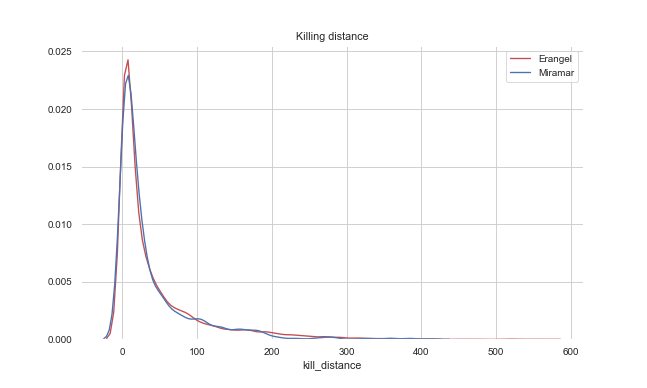

In [569]:
sns.set
plt.figure(figsize=(10,6))
sns.distplot(kill_dis[kill_dis['map'] == 'ERANGEL']['kill_distance'],hist=False, color = 'r',label='Erangel')
sns.distplot(kill_dis[kill_dis['map'] == 'MIRAMAR']['kill_distance'],hist=False, color = 'b',label='Miramar')
plt.title('Killing distance')
plt.legend()
plt.show()

### Killing distance of firearms

In [718]:
# top20_firearm = killed_firearm.head(20).killed_by.values
top15_firearm = ['M416', 'SCAR-L', 'M16A4', 'AKM', 'UMP9', 'S1897', 'Mini 14','Kar98k', \
                 'S686', 'SKS', 'S12K', 'Micro UZI', 'Grenade','Tommy Gun', 'P1911']

In [719]:
kill.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_name: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: double (nullable = true)
 |-- killer_position_y: double (nullable = true)
 |-- map: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_name: string (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: double (nullable = true)
 |-- victim_position_y: double (nullable = true)
 |-- id: long (nullable = true)
 |-- kill_distance: double (nullable = true)



In [722]:
kill0 = kill.select('map','killed_by','killer_position_x','victim_position_x','killer_position_y','victim_position_y').dropna()
kill0 = kill0.withColumn('kill_distance',F.sqrt((kill.killer_position_x/100-kill.victim_position_x/100)**2+
                                      (kill.killer_position_y/100-kill.victim_position_y/100)**2))

In [727]:
firearm_dis = kill0.sample(withReplacement = False, fraction = 0.00015, seed=0).select('killed_by','kill_distance').dropna().\
filter(kill.kill_distance<=650)
firearm_dis = firearm_dis.filter(F.col('killed_by').isin(top15_firearm))
firearm_dis.show(5)

+---------+------------------+
|killed_by|     kill_distance|
+---------+------------------+
|      AKM| 7.848963880665972|
|    S1897|3.3325961351477673|
|     M416| 78.11720588961172|
|   SCAR-L|28.520161745684465|
|    M16A4|2.2914399403003602|
+---------+------------------+
only showing top 5 rows



In [731]:
fd1 = firearm_dis.filter(firearm_dis['killed_by']=='M416').selectExpr('kill_distance as M416').toPandas()
fd2 = firearm_dis.filter(firearm_dis['killed_by']=='SCAR-L').selectExpr('kill_distance as SCAR_L').toPandas()
fd3 = firearm_dis.filter(firearm_dis['killed_by']=='M16A4').selectExpr('kill_distance as M16A4').toPandas()
fd4 = firearm_dis.filter(firearm_dis['killed_by']=='AKM').selectExpr('kill_distance as AKM').toPandas()
fd5 = firearm_dis.filter(firearm_dis['killed_by']=='UMP9').selectExpr('kill_distance as UMP9').toPandas()
fd6 = firearm_dis.filter(firearm_dis['killed_by']=='S1897').selectExpr('kill_distance as S1897').toPandas()
fd7 = firearm_dis.filter(firearm_dis['killed_by']=='Mini 14').selectExpr('kill_distance as Mini_14').toPandas()
fd8 = firearm_dis.filter(firearm_dis['killed_by']=='Kar98k').selectExpr('kill_distance as Kar98k').toPandas()
fd9 = firearm_dis.filter(firearm_dis['killed_by']=='S686').selectExpr('kill_distance as S686').toPandas()
fd10 = firearm_dis.filter(firearm_dis['killed_by']=='SKS').selectExpr('kill_distance as SKS').toPandas()
fd11 = firearm_dis.filter(firearm_dis['killed_by']=='S12K').selectExpr('kill_distance as S12K').toPandas()
fd12 = firearm_dis.filter(firearm_dis['killed_by']=='Micro UZI').selectExpr('kill_distance as Micro_UZI').toPandas()
fd13 = firearm_dis.filter(firearm_dis['killed_by']=='Grenade').selectExpr('kill_distance as Grenade').toPandas()
fd14 = firearm_dis.filter(firearm_dis['killed_by']=='Tommy Gun').selectExpr('kill_distance as Tommy_Gun').toPandas()
fd15 = firearm_dis.filter(firearm_dis['killed_by']=='P1911').selectExpr('kill_distance as P1911').toPandas()

In [745]:
fd1 = fd1.reset_index(drop=True).T
fd2 = fd2.reset_index(drop=True).T
fd3 = fd3.reset_index(drop=True).T
fd4 = fd4.reset_index(drop=True).T
fd5 = fd5.reset_index(drop=True).T
fd6 = fd6.reset_index(drop=True).T
fd7 = fd7.reset_index(drop=True).T
fd8 = fd8.reset_index(drop=True).T
fd9 = fd9.reset_index(drop=True).T
fd10 = fd10.reset_index(drop=True).T
fd11 = fd11.reset_index(drop=True).T
fd12 = fd12.reset_index(drop=True).T
fd13 = fd13.reset_index(drop=True).T
fd14 = fd14.reset_index(drop=True).T
fd15 = fd15.reset_index(drop=True).T
fd = [fd1,fd2,fd3,fd4,fd5,fd6,fd7,fd8,fd9,fd10,fd11,fd12,fd13,fd14,fd15]
firearm_dist = pd.concat(fd)

In [776]:
firearm_dist = firearm_dist.reset_index().rename(columns = {'index':'firearm'})
firearm_dist['type'] = firearm_dist.firearm.values
gun_type = {'M416':'Assault_rifle','SCAR_L':'Assault_rifle','M16A4':'Assault_rifle','AKM':'Assault_rifle','S1897':'Sniper_rifle','S686': 'Shotgun','S12K': 'Shotgun', \
         'Mini_14':'Sniper_rifle','Kar98k':'Sniper_rifle','SKS':'Sniper_rifle','UMP9':'Submachine_gun','Micro_UZI':'Submachine_gun','Tommy_Gun':'Submachine_gun',\
         'Grenade':'Grenade','P1911':'Pistol'}
firearm_dist['type'] = firearm_dist['type'].map(gun_type)

<IPython.core.display.Javascript object>


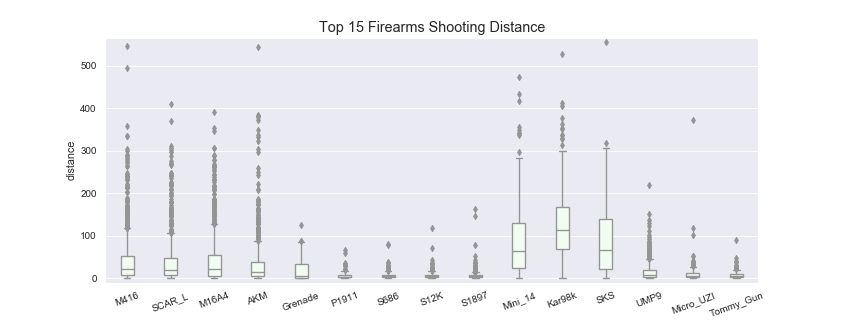

Text(0.5, 1.0, 'Top 15 Firearms Shooting Distance')

In [920]:
# sns.set()
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(13,5))
plt.ylim([-10,565])

sns.boxplot(data=firearm_dist.sort_values(by=['type'],ascending=True).set_index('firearm').drop(['type'],axis=1).T\
                  , width=.3, color='honeydew')
ax.set(ylabel='distance',xlabel='firearm')
plt.xticks(rotation=20)
plt.title('Top 15 Firearms Shooting Distance', fontsize=16)

## `Feature importance `

<font color = 'slategrey'> Placement prediction's feature importance from Random Forest model

In [10]:
a={0: 0.0056, 1: 0.3974, 2: 0.0357, 3: 0.0005, 4: 0.0015, 5: 0.0324, 6: 0.1251, 7: 0.4019}
A = pd.DataFrame([a]).rename(columns={0:'party_size',1:'avg_survive_time',2:'total_kill',3:'total_assists',4:'total_dbno',5:'total_damage',\
 6:'avg_ride_dist',7:'avg_walk_dist'}).T.sort_values(by=0,ascending=True)
A.head()

0
total_assists  0.0005
total_dbno     0.0015
party_size     0.0056
total_damage   0.0324
total_kill     0.0357

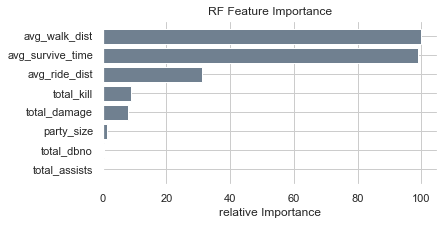

In [106]:
# sns.set(font_scale=1.5)
# sns.set_style("darkgrid")
rc = {'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.family':'sans-serif',
      'font.size' : 12}
plt.rcParams.update(rc)
# sns.set()
fig, axes = plt.subplots(figsize=(6,3)) 
feature_importance = 100.0 * (A[0]/(A[0].max()))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 1

plt.barh(pos, feature_importance[sorted_idx], align='center', color='slategrey')
plt.yticks(pos, A.index.values)

plt.xlabel('relative Importance')
plt.title('RF Feature Importance');

<font color = 'slategrey'> Placement prediction's feature importance from Gradient Boosted Trees model

In [102]:
b={0: 0.2181, 1: 0.2093, 2: 0.2248, 3: 0.037, 4: 0.0042, 5: 0.0079, 6: 0.0284, 7: 0.2702}
B = pd.DataFrame([b]).rename(columns={0:'party_size',1:'avg_survive_time',2:'total_kill',3:'total_assists',4:'total_dbno',5:'total_damage',\
 6:'avg_ride_dist',7:'avg_walk_dist'}).T.sort_values(by=0,ascending=True)
B.head()

0
total_dbno        0.0042
total_damage      0.0079
avg_ride_dist     0.0284
total_assists     0.0370
avg_survive_time  0.2093

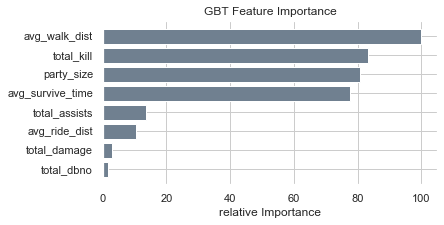

In [105]:
fig, axes = plt.subplots(figsize=(6,3)) 
feature_importance = 100.0 * (B[0]/(B[0].max()))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 1

plt.barh(pos, feature_importance[sorted_idx], align='center', color='slategrey')
plt.yticks(pos, B.index.values)

plt.xlabel('relative Importance')
plt.title('GBT Feature Importance');
